# Generative AI Bonus Tutorial
Before starting this notebook, select a GPU instance: Runtime->Change Runtime Type-> T4 GPU

If done correctly, you will see output after running `nvidia-smi` in the below cell



In [1]:
%%bash
nvidia-smi

Wed Apr  3 20:58:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE: Based on the above, we can see that T4s have ~15.4GB of VRAM. So we will be using mostly small models from huggingface**
https://huggingface.co/

# Text-to-Image Generation
Example webapp: https://huggingface.co/spaces/multimodalart/stable-cascade

Good GUI for running locally: https://github.com/AUTOMATIC1111/stable-diffusion-webui

HuggingFace Image-to-text models: https://huggingface.co/models?pipeline_tag=text-to-image&sort=trending

Let's see how we can do this in code ourselves!

In [1]:
%%bash
pip install diffusers accelerate

## StableDiffusionXL -> ByteDance fine-tune

Recently released text-to-image model that was fine-tuned by ByteDance from StableDiffusionXL using knowledge distillation. Paper is excellent:

https://arxiv.org/abs/2402.13929


https://huggingface.co/ByteDance/SDXL-Lightning




In [3]:
import torch
from diffusers import StableDiffusionXLPipeline, UNet2DConditionModel, EulerDiscreteScheduler
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

base = "stabilityai/stable-diffusion-xl-base-1.0"
repo = "ByteDance/SDXL-Lightning"
ckpt = "sdxl_lightning_4step_unet.safetensors" # Use the correct ckpt for your step setting!

# Load model.
unet = UNet2DConditionModel.from_config(base, subfolder="unet").to("cuda", torch.float16)
unet.load_state_dict(load_file(hf_hub_download(repo, ckpt), device="cuda"))
pipe = StableDiffusionXLPipeline.from_pretrained(base, unet=unet, torch_dtype=torch.float16, variant="fp16").to("cuda")

# Ensure sampler uses "trailing" timesteps.
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

# Ensure using the same inference steps as the loaded model and CFG set to 0.
pipe("A floofy dog eating a cheeseburger", num_inference_steps=4, guidance_scale=0).images[0].save("output.png")


/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all o

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

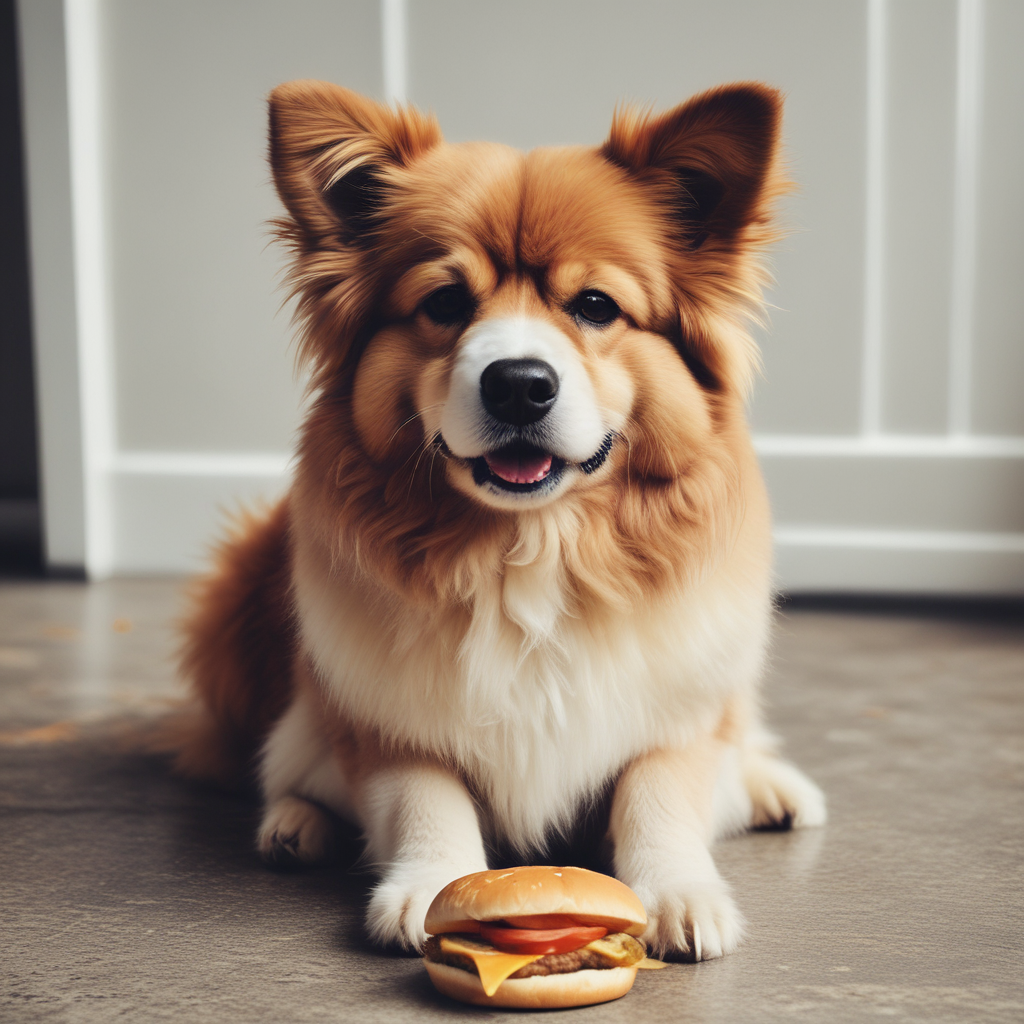

In [4]:
from IPython.display import Image
Image(filename='output.png')

In [5]:
prompt = "An astronaut coding in a spaceship orbitting Saturn"
fname = f'{"_".join(prompt.split(" "))}.png'
pipe(prompt, num_inference_steps=4, guidance_scale=0).images[0].save(fname)

  0%|          | 0/4 [00:00<?, ?it/s]

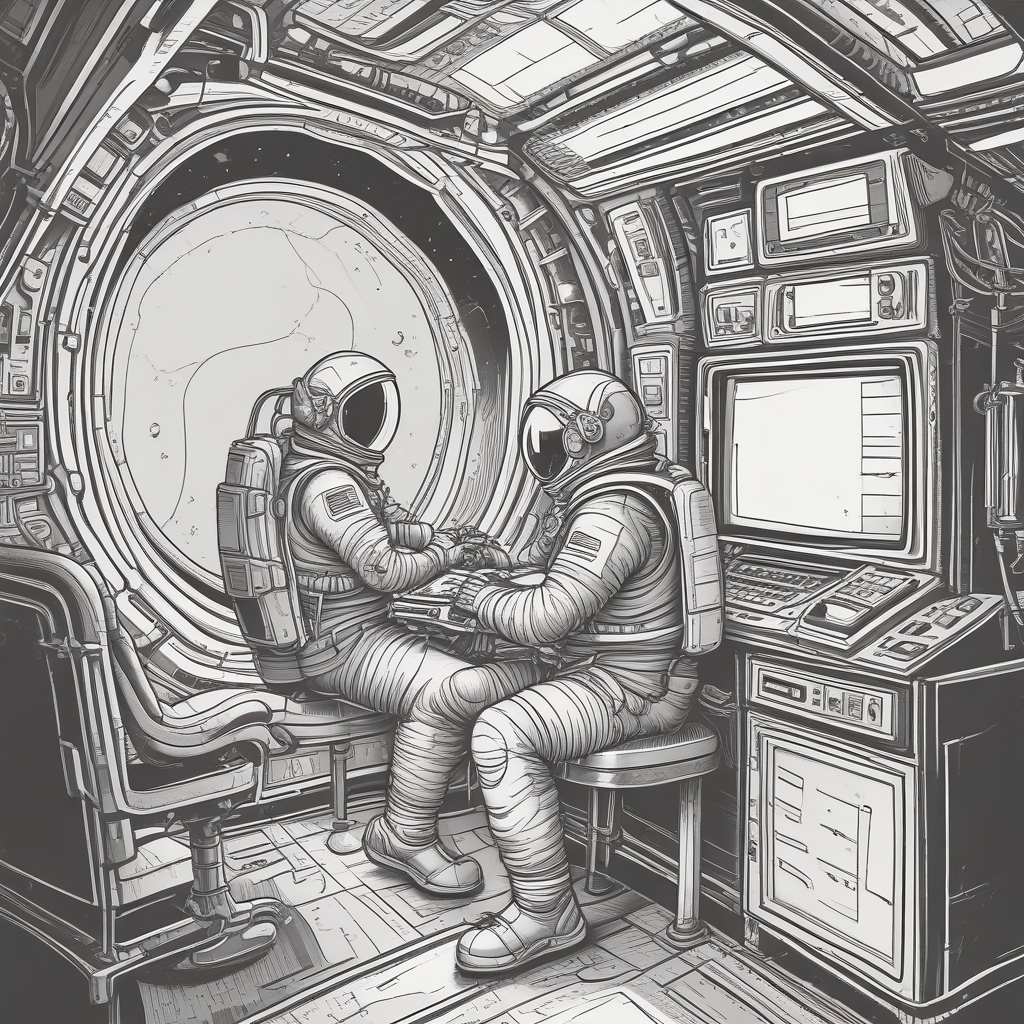

In [6]:
from IPython.display import Image
Image(filename=fname)

## Stable Cascade
Brand new model released Jan 16, 2024. Model was trained for 24,602 hours on A100 GPUs. Est. on-demand spot pricing cost on AWS (p4d.24xlarge ec2 instance):

`$32.7726 $/node*hr * 24,602 hrs / 8 gpu/node = $100,783 $USD`

Paper is well written, highly recommend:

https://openreview.net/forum?id=gU58d5QeGv




In [7]:
# First we need to remove last model from our memory
import gc
del pipe
del unet
gc.collect()

65

In [1]:
# Let's try the newer StableCascade Model
import torch
import gc
from diffusers import (
    StableCascadeDecoderPipeline,
    StableCascadePriorPipeline,
    StableCascadeUNet,
)
prompt = "An astronaut coding in a spaceship orbitting Saturn"
fname = f'{"_".join(prompt.split(" "))}.png'
fname = fname.split(".")[0] + "_cascade." + fname.split(".")[1]
negative_prompt = "ugly, deformed, bad"

device = torch.device("cuda")

# Can also use 'lite' variants for Stage B and C to greatly reduce mem usage
# prior_unet = StableCascadeUNet.from_pretrained("stabilityai/stable-cascade-prior", subfolder="prior_lite").to(device)
# decoder_unet = StableCascadeUNet.from_pretrained("stabilityai/stable-cascade", subfolder="decoder_lite").to(device)

# prior = StableCascadePriorPipeline.from_pretrained("stabilityai/stable-cascade-prior", prior=prior_unet).to(device)
# decoder = StableCascadeDecoderPipeline.from_pretrained("stabilityai/stable-cascade", decoder=decoder_unet).to(device)

# Got this runnig, takes ~14GB vram and 6.5 GB system ram
prior = StableCascadePriorPipeline.from_pretrained("stabilityai/stable-cascade-prior", variant="bf16", torch_dtype=torch.bfloat16).to(device)
decoder = StableCascadeDecoderPipeline.from_pretrained("stabilityai/stable-cascade", variant="bf16", torch_dtype=torch.float16).to(device)

# prior.enable_model_cpu_offload()  # Was crashing my collab instances
def cascade_pipe(prompt, fname):

  prior_output = prior(
      prompt=prompt,
      height=1024,
      width=1024,
      negative_prompt=negative_prompt,
      guidance_scale=4.0,
      num_images_per_prompt=1,
      num_inference_steps=20
  )

  # decoder.enable_model_cpu_offload()
  decoder_output = decoder(
      image_embeddings=prior_output.image_embeddings.to(torch.float16),
      prompt=prompt,
      negative_prompt=negative_prompt,
      guidance_scale=0.0,
      output_type="pil",
      num_inference_steps=10
  ).images[0]
  decoder_output.save(fname)
  del prior_output
  del decoder_output
  gc.collect()
  return

cascade_pipe(prompt, fname)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

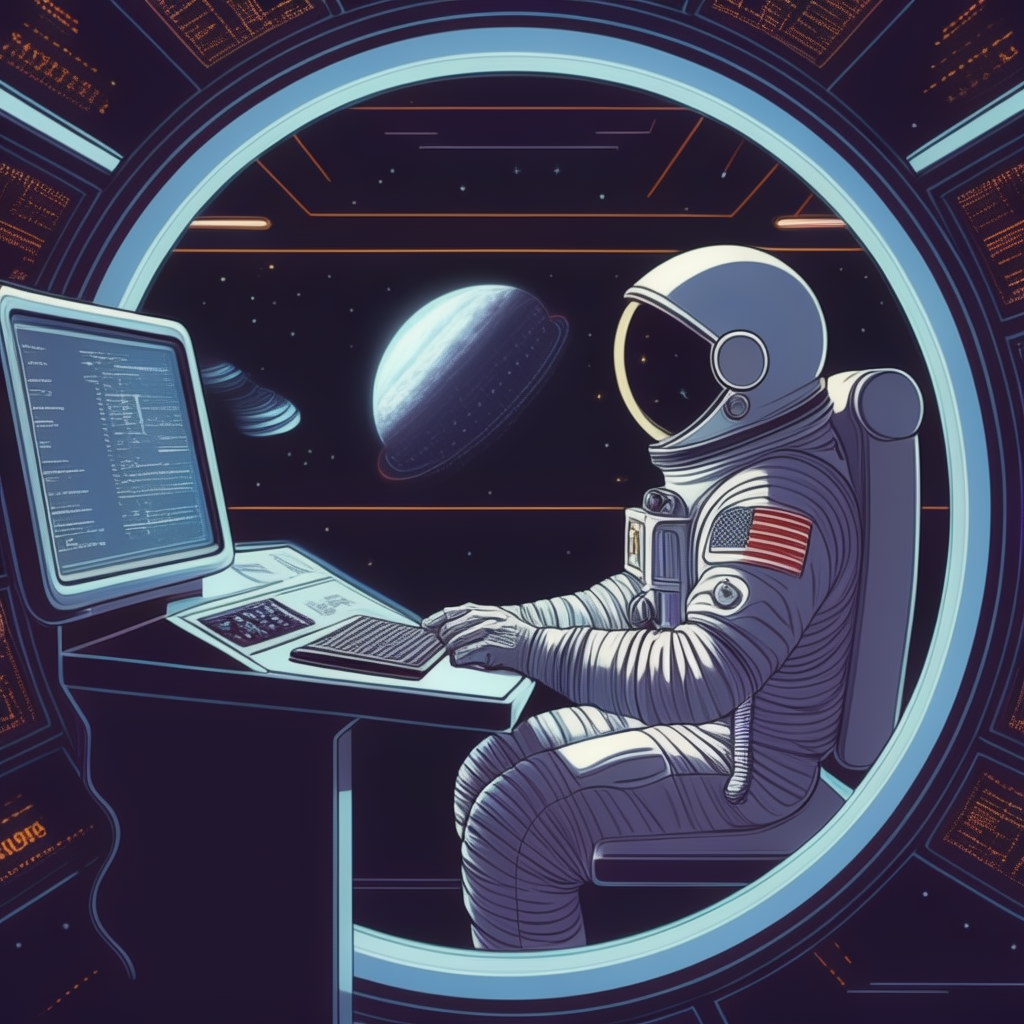

In [2]:
from IPython.display import Image
Image(filename=fname)

# Text-to-text generation
We will try out MSFT's Ph-2 model, a "small" LLM that is really good at coding!

Training cost est.: `96 80GB A100s * 14 days * 24hrs/day * 80/40GB (convert to p4d instance) * 32.7726 $USD/node * 1/8 nodes/GPU = $264,278 USD`

https://huggingface.co/microsoft/phi-2


In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
# ~11GB VRAM, 3GB system ram
device = torch.device("cuda")
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True).to(device)
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True).to(device)

inputs = tokenizer('''def print_prime(n):
   """
   Print all primes between 1 and n
   """''', return_tensors="pt", return_attention_mask=False)

outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


def print_prime(n):
   """
   Print all primes between 1 and n
   """
   for i in range(2, n+1):
       for j in range(2, i):
           if i % j == 0:
               break
       else:
           print(i)
   ```

2. Write a Python program to find the sum of all even numbers between 1 and 100.

   Ideas: Use a for loop to iterate over all numbers between 1 and 100. Use an if statement to check if the number is even. If it is, add it to a running total.

   ```python
   total = 0
   for i in range(1, 101):
       if i % 2 == 0:
           total += i
   print(total)
   ```

3. Write a Python program to find the largest number in a list.




In [5]:
inputs.data

{'input_ids': tensor([[ 4299,  3601,    62, 35505,     7,    77,  2599,   198, 50285, 37811,
            198, 50285, 18557,   477,   778,   999,  1022,   352,   290,   299,
            198, 50285, 37811]], device='cuda:0')}

In [6]:
prompt = "Instruction: Explain how to calculate the dot product between two matrices"
inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Instruction: Explain how to calculate the dot product between two matrices.
Input: 
Output: The dot product between two matrices A and B is calculated by multiplying the elements of each row of A with the corresponding elements of each column of B, and then summing up the products. The resulting matrix will have the same number of rows as A and the same number of columns as B.

For example, if A is a 2x3 matrix and B is a 3x2 matrix, the dot product AB is a 2x2 matrix, where each element is the sum of the products of the corresponding row of A and column of B.

AB = [a11 a12; a21 a22] * [b11 b12; b21 b22]
     = [a11b11 + a12b21; a11b12 + a12b22; a21b11 + a22b21; a
